In [1]:
%%capture
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy

Recording Datasets
===================

Several use-cases may require for data generated by Hermes during measurement campaigns or simulation runtime to be stored within the filesystem for later use.

For this purpose, the Hermes API offers the record and replay functions of scenarios. During recording, all information processed by devices and operators is stored within HDF5 files.
During replaying, the information can then be used as a basis of further evaluations, or the HDF5 file can be opened in other environments such as a Matlab workspace.

To demonstrate this functionality, let us first define a simplex link of an OFDM communication within two devices in an indoor office scenario without direct line of sight between transmitting and receiving device:

In [2]:
import numpy as np

from hermespy.channel import IndoorOffice, LOSState, OfficeType
from hermespy.core import dB, Transformation
from hermespy.modem import SimplexLink, OFDMWaveform, OrthogonalLeastSquaresChannelEstimation, ZeroForcingChannelEqualization, GridElement, GridResource, SymbolSection, ElementType
from hermespy.simulation import SimulationScenario, N0, StaticTrajectory

# Define a new simulated scenario
scenario = SimulationScenario(seed=42)
scenario.noise_level = N0(dB(-100))

# Consider two dedicated devices at a carrier frequency of 800 MHz
tx_device = scenario.new_device(carrier_frequency=800e6)
rx_device = scenario.new_device(carrier_frequency=800e6)

# Specify the device's location within the scenario
tx_device.trajectory = StaticTrajectory(Transformation.From_Translation(np.array([0., 0., 0.])))
rx_device.trajectory = StaticTrajectory(Transformation.From_Translation(np.array([10., 10., 0.])))

# Configure an indoor office channel on the device's link
scenario.set_channel(tx_device, rx_device, IndoorOffice(office_type=OfficeType.OPEN, expected_state=LOSState.LOS))
scenario.channel(tx_device, tx_device).gain = 0.0
scenario.channel(rx_device, rx_device).gain = 0.0

# The devices communicate via an OFDM waveform consisting of four identical symbols
waveform = OFDMWaveform(grid_resources=[GridResource(repetitions=50, elements=[GridElement(ElementType.DATA, 11), GridElement(ElementType.REFERENCE, 1)])],
                        grid_structure=[SymbolSection(4, [0])])
waveform.channel_equalization = ZeroForcingChannelEqualization()
waveform.channel_estimation = OrthogonalLeastSquaresChannelEstimation()

modem = SimplexLink(waveform=waveform)
modem.connect(tx_device, rx_device)

Now, a single data drop can be simulated by calling the scenario's drop routine.
Internally, all device and scenario subroutines will be called to generate the transmitted waveforms, propagate over the channels and finally estimated the transmitted information at the receiver.

In [3]:
drop = scenario.drop()

This drop now esentially contains a copy of the full scenario state consisting of all device's transmitting and received information, which can be visualized by calling the respectives plot and visualization routines.

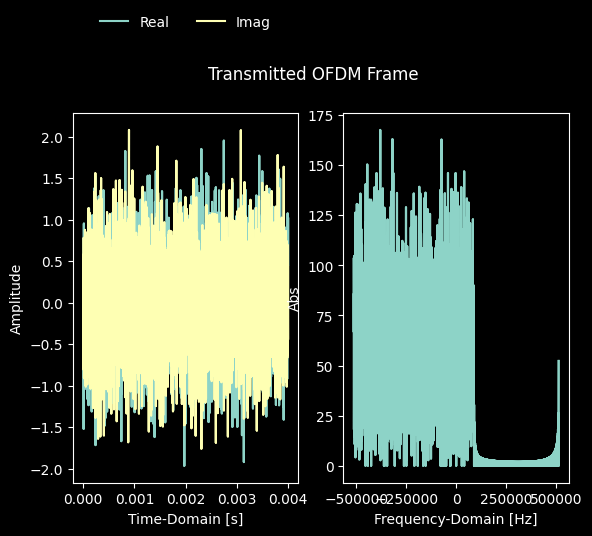

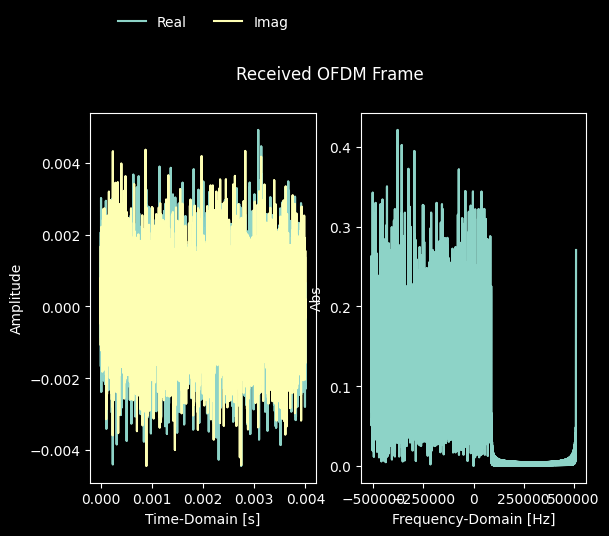

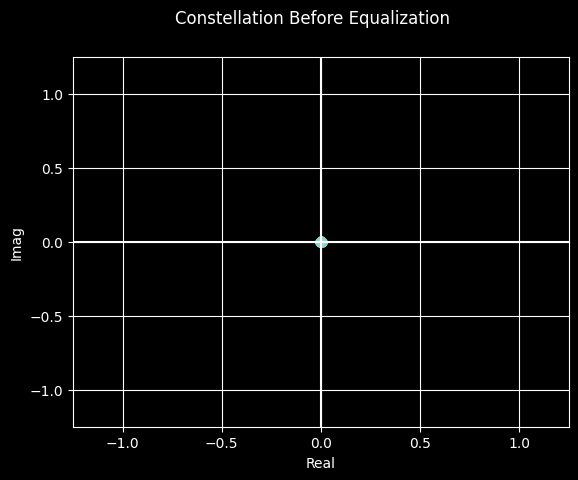

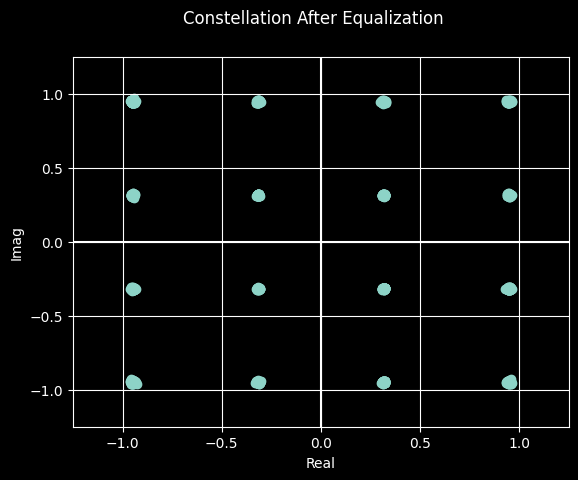

In [4]:
import matplotlib.pyplot as plt


_ = drop.device_transmissions[0].mixed_signal.plot(title='Transmitted OFDM Frame')
_ = drop.device_receptions[1].baseband_signal.plot(title='Received OFDM Frame')
_ = drop.device_receptions[1].operator_receptions[0].symbols.plot_constellation(title='Constellation Before Equalization')
_ = drop.device_receptions[1].operator_receptions[0].equalized_symbols.plot_constellation(title='Constellation After Equalization')

plt.show()

Now that we demonstrated what kind of information a drop consists of, all we need to do is start recording drops into datasets:

In [5]:
# Record a few drops into a dataset
num_drops = 10
scenario.record('dataset.h5', overwrite=True)
recorded_drops = [scenario.drop() for _ in range(num_drops)]

# Properly close the file
scenario.stop()

We are now able to recall the full scenario configuration, including devices,
operators and their generated information from the filesystem.

Let' just compare the first few received constellations for demonstration:

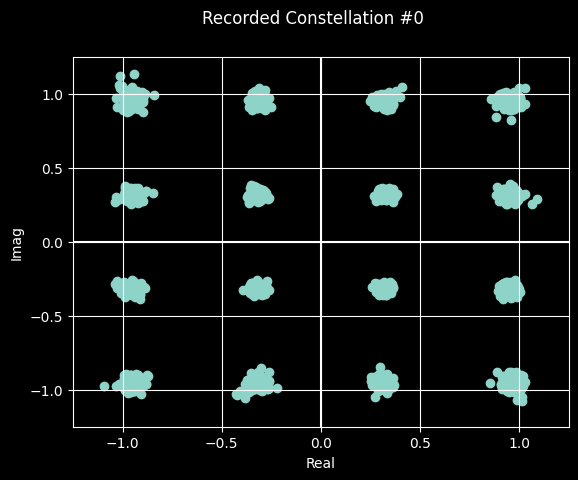

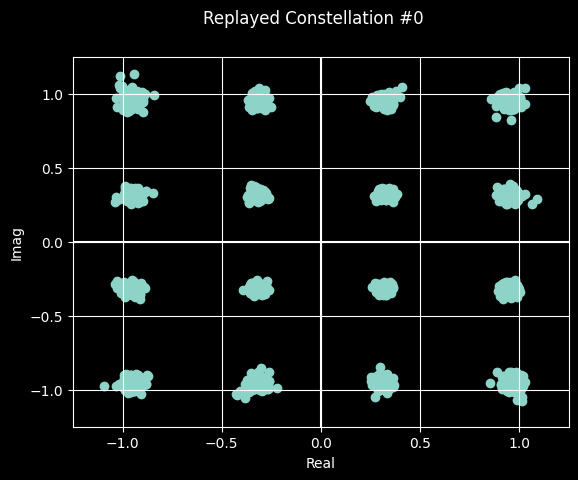

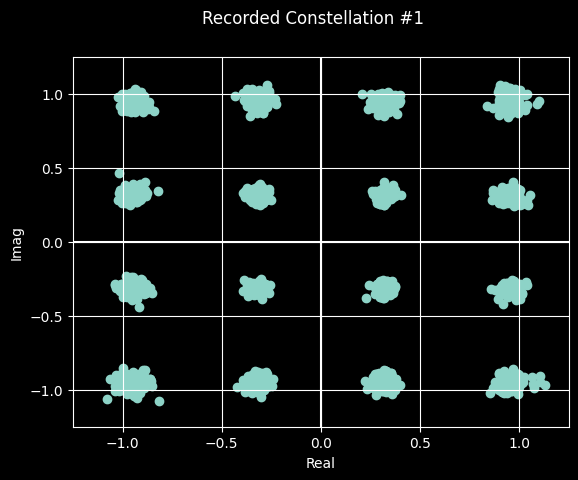

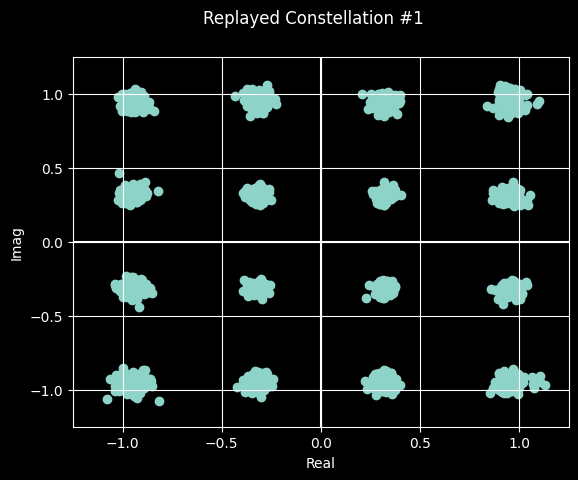

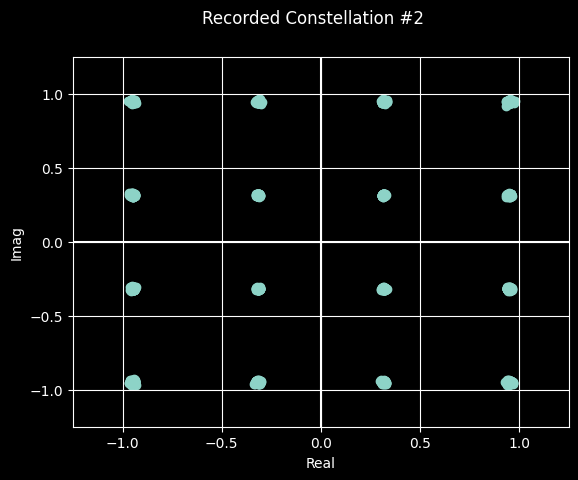

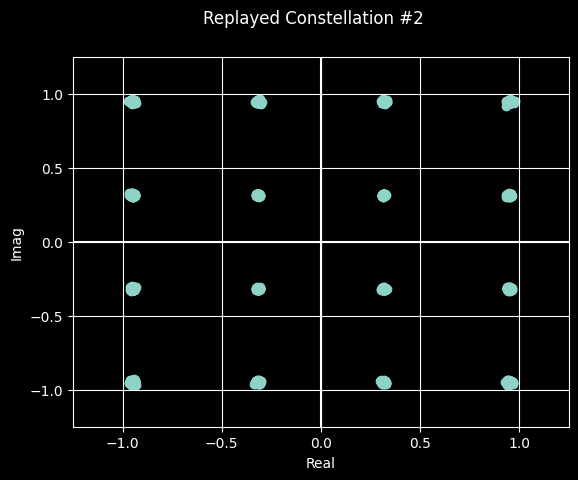

In [6]:
# Deserialize a scenario from a dataset
recalled_scenario = SimulationScenario.Replay('dataset.h5')

# Recall a few drops
num_recalled_drops = 3
for n, recorded_drop in enumerate(recorded_drops[:num_recalled_drops]):

    recalled_drop = recalled_scenario.drop()
    
    # Plot the equalized constellation of recorded and replayed drops
    recorded_drop.device_receptions[1].operator_receptions[0].equalized_symbols.plot_constellation(title=f'Recorded Constellation #{n}')
    recalled_drop.device_receptions[1].operator_receptions[0].equalized_symbols.plot_constellation(title=f'Replayed Constellation #{n}')

# Properly close all streams, just in case
recalled_scenario.stop()

plt.show()

As we can clearly deduce, the recalled information is identical to the initially generated information.